# COVID Hospital mapping for Ethiopia

In [1]:
# general tools
from preprocessing import get_population_data, split, n_closest_geodetic
import numpy as np
import rasterio
import logging
import pandas as pd
from rasterio.windows import Window
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import requests #http framework to make mhvpl requests for routes
import json # handle response as json
import pickle
log = logging.getLogger(__name__)

## Prepare population data

In [2]:
CRS ='epsg:4326'
LOCATION = 'ethiopia'
DATAPATH = 'data/' + LOCATION
RAWFILEPATH  = DATAPATH +  '/raw'
PROCESSEDFILEPATH = DATAPATH + '/processed'
RESULTSFILEPATH = DATAPATH + '/results'

# Facebooks HRSL dataset
map_file = RAWFILEPATH+"/population_eth_2018-10-01.tif"


In [7]:
#Initial scan the raster map with big windows
origins=pd.DataFrame()
window=2000

with rasterio.open(map_file) as src:
    a=src.xy(0,1)
    for left_x in np.arange(0,src.width,window):
        for top_y in np.arange(0,src.height,window):
            out=get_population_data(map_file,left_x,top_y,window,plot=False)
            if out != {}:
                origins=origins.append([out])
        print("%i/%i\r"%(left_x,src.width),end="")

In [8]:
#Perform a splitting pass
#Run this cell as many times as you want to split the windows
print("%i regions need splitting"%len(origins[origins['split']==True]))
olen=len(origins)
for i in np.arange(olen):
    print("%i/%i\r"%(i+1,olen),end="")
    if origins.iloc[i,origins.columns.get_loc('split')] == True:
        origins.iloc[i,origins.columns.get_loc('split')]='done'
        s=split(map_file,origins.iloc[i])
        origins=origins.append(s,sort=False)
print("We now have %i regions, %i will be split in next round"%(len(origins),len(origins[origins['split']==True])))

348 regions need splitting
We now have 1959 regions, 1278 will be split in next round


In [9]:
# Keep the regions with population>1
# and filter out the regions which have been split
origins=origins[origins['tot_pop']>0]
origins=origins[origins['split']!='done']
print("We have %i regions of size %i, %i with population >0"%
      (len(origins),min(origins['window']),len(origins[origins['tot_pop']>0])))

We have 1278 regions of size 1000, 1278 with population >0


In [10]:
#transform into GeoDataFrame
origins=gpd.GeoDataFrame(origins,crs='epsg:4326', geometry=[Point(xy) for xy in zip(origins['center_lon'], origins['center_lat'])])
origins.geometry=origins.apply(lambda r: box(r.left_lon, r.bottom_lat, r.right_lon, r.top_lat, ccw=False),axis=1)
origins.reset_index(drop=True)

,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split,geometry
0,1000,0,1000,23000,24000,32.998333,8.463889,33.276111,8.186111,33.137222,8.325000,1000000,5,231.448715,True,"POLYGON ((32.99833 8.18611, 32.99833 8.46389, ..."
1,1000,1000,2000,23000,24000,33.276111,8.463889,33.553889,8.186111,33.415000,8.325000,1000000,868,38351.499530,True,"POLYGON ((33.27611 8.18611, 33.27611 8.46389, ..."
2,1000,0,1000,24000,25000,32.998333,8.186111,33.276111,7.908333,33.137222,8.047222,1000000,7,3283.341795,True,"POLYGON ((32.99833 7.90833, 32.99833 8.18611, ..."
3,1000,0,1000,25000,26000,32.998333,7.908333,33.276111,7.630556,33.137222,7.769444,1000000,71,33302.466778,True,"POLYGON ((32.99833 7.63056, 32.99833 7.90833, ..."
4,1000,1000,2000,24000,25000,33.276111,8.186111,33.553889,7.908333,33.415000,8.047222,1000000,36,3026.784975,True,"POLYGON ((33.27611 7.90833, 33.27611 8.18611, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,1000,52000,53000,24000,25000,47.442778,8.186111,47.720556,7.908333,47.581667,8.047222,1000000,24,428.380967,True,"POLYGON ((47.44278 7.90833, 47.44278 8.18611, ..."
1274,1000,52000,53000,25000,26000,47.442778,7.908333,47.720556,7.630556,47.581667,7.769444,1000000,254,4533.698567,True,"POLYGON ((47.44278 7.63056, 47.44278 7.90833, ..."
1275,1000,53000,54000,24000,25000,47.720556,8.186111,47.998333,7.908333,47.859444,8.047222,824000,32,571.174623,True,"POLYGON ((47.72056 7.90833, 47.72056 8.18611, ..."
1276,1000,53000,54000,25000,26000,47.720556,7.908333,47.998333,7.630556,47.859444,7.769444,824000,33,589.023830,True,"POLYGON ((47.72056 7.63056, 47.72056 7.90833, ..."


In [11]:
# save shapefile
origins.to_file(driver = 'GeoJSON', filename= PROCESSEDFILEPATH+'/origins_'+str(len(origins))+'.geojson')
origins.to_file(driver = 'ESRI Shapefile', filename = PROCESSEDFILEPATH+'/origins_'+str(len(origins))+'.shp')

## Import hospital locations

In [13]:
hospital_path = RAWFILEPATH+"/ethiopia_hospitals.shp"
df = gpd.read_file(hospital_path).to_crs(CRS)
df['lon']=df.geometry.centroid.x
df['lat']=df.geometry.centroid.y
df['name']=df['Facility n']
hospitals=df[['name','lon','lat','geometry']]
print("There are %i hospitals"%len(hospitals))
hospitals.reset_index(drop=True)


There are 151 hospitals


,name,lon,lat,geometry
0,Addis Ketema Hospital 1,38.7258,9.0256,POINT (38.72580 9.02560)
1,Addis Ketema Hospital 2,38.7228,9.0328,POINT (38.72280 9.03280)
2,Addis Ketema Hospital 3,38.7257,9.0358,POINT (38.72570 9.03580)
3,Addis Ketema Hospital 4,38.7355,9.0295,POINT (38.73550 9.02950)
4,Akaki Kaliti Hospital,38.7676,8.9512,POINT (38.76760 8.95120)
...,...,...,...,...
146,Yetibo Mercy Hospital,38.2921,8.1202,POINT (38.29210 8.12020)
147,Yirga Alem Hospital,38.4158,6.7247,POINT (38.41580 6.72470)
148,Yirgalem Hospital,38.3896,6.7431,POINT (38.38960 6.74310)
149,May Adirasha Hospital,38.3044,14.1141,POINT (38.30440 14.11410)


In [14]:
# Save or load data for later usage
# SAVE
with open(PROCESSEDFILEPATH+'/'+LOCATION+'_'+str(len(origins))+'-h-o.pickle', 'wb') as handle:
    pickle.dump([hospitals,origins], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# LOAD
with open(PROCESSEDFILEPATH+'/'+LOCATION+'_1278-h-o.pickle', 'rb') as handle:
    hospitals,origins = pickle.load(handle)

In [4]:
# prepare hospital locations to be fed into the OSRM engine as strings
hospitals_loc=";".join([str(i[1])+','+str(i[0]) for i in hospitals[['lat','lon']].values])


## Calculate travel times from each region to the nearest hospital# osrm server address

In [16]:
osrm_server="http://0.0.0.0:5000"
server=osrm_server+"/table/v1/driving/"

batch=1
POI='hospital'

buffer=10/60.  #10 minutes, in hours
overalpenalty=1.05  #5%

# create a new column in the Geodataframe for the time and distance
origins['t_'+POI]=-1
origins['m_'+POI]=-1

for i in np.arange(origins.shape[0]/batch):
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),origins.shape[0]),end="\r")
    origins_batch=origins.iloc[int(batch*i):].head(n=batch)

    destinations=";".join([str(i[1])+','+str(i[0]) for i in origins_batch[['center_lat','center_lon']].values])
    destinations_number=origins_batch.index

    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitals))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitals),len(hospitals)+len(origins_batch))])

    fullurl= server+hospitals_loc+";"+destinations+trail
    response = requests.get(fullurl)

    response.raise_for_status()
    durations_matrix=json.loads(response.text)['durations']
    durations=[]
    hospital_min=[]
    try:
        for origin in np.arange(np.shape(durations_matrix)[0]):
            durations+=[min(durations_matrix[origin])]
            hospital_min+=[np.argmin(durations_matrix[origin])]
        print(durations)
        print(destinations_number)
        print('\n')
        for j in np.arange(len(durations)):
            print(destinations_number[j])
            origins.loc[[destinations_number[j]], ['t_'+POI]]=buffer+durations[j]/60./60.*overalpenalty
            origins.loc[[destinations_number[j]], ['m_'+POI]]=hospital_min[j]
    except:
        logging.warning('Batch '+str(i)+' processing failed. Check if OSRM data covers area.')
        continue
    break

[17624.5]ch 0, [0,1] of 1278
Int64Index([0], dtype='int64')


0


In [12]:
# save files
origins.to_file(RESULTSFILEPATH+'/origins_'+str(len(origins))+'_results.geojson', driver='GeoJSON')
origins.to_file(RESULTSFILEPATH+'/origins_'+str(len(origins))+'_results.shp', driver='ESRI Shapefile')
with open(RESULTSFILEPATH+'/'+LOCATION+'_'+str(len(origins))+'-results.pickle', 'wb') as handle:
    pickle.dump([hospitals,origins], handle, protocol=pickle.HIGHEST_PROTOCOL)

ERROR:fiona._env:data/ethiopia/results/origins_1278_results.geojson: No such file or directory


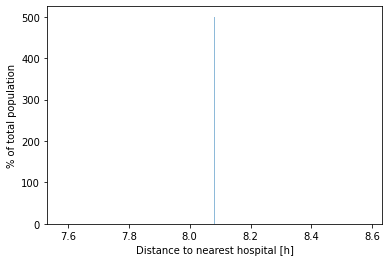

In [13]:
# Plot
%matplotlib inline
plt.figure()
origins['t_'+POI].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% of total population')
plt.xlabel('Distance to nearest '+POI+' [h]')
plt.savefig('travel_time_dist.pdf')
plt.show()

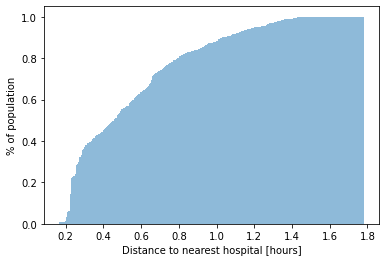

In [110]:
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=True,density=True,weights=origins['tot_pop'])
plt.ylabel('% of population')
plt.xlabel('Distance to nearest '+usual_origin+' [hours]')
plt.show()

In [108]:
for i in np.arange(10,101,10):
    print("El %i%% de la población en Asturias tarda %2.1f minutos en llegar al destino: %s"%
         (i,np.percentile(weight_array(origins['t_'+usual_origin].values*60, origins['tot_pop'].values), i),usual_origin))

NameError: name 'weight_array' is not defined

In [ ]:
lejos=origins[origins['t_'+usual_origin]>1].sort_values(by='t_'+usual_origin,ascending=False)

for index,lugar in lejos.head(n=5).iterrows():
    print("%i personas en %s tardan %2.1f horas en llegar al destino: %s"%
         (lugar["POBLACION"],lugar["NOMBRE"],lugar["t_"+usual_origin],usual_origin))
    get_route_link([hospitales.loc[lugar['m_hospital']]['lon'],hospitales.loc[lugar['m_hospital']]['lat']],
                   [lugar['lon'],lugar['lat']])


origins.to_file("data/origins.geojson", driver="GeoJSON")